# Instructor Task
## Dataset
- [Here](https://s3-us-west-2.amazonaws.com/ga-dat-2015-suneel/datasets/breast-cancer.csv) is the dataset.
- [Here](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names) is a description of the data. Ignore column 0 as it is merely the ID of a patient record.

### Imports

First we import the modules required by the project.

In [256]:
import pandas
import numpy
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

## 1. Read in the data

We read in the Wisconsin Diagnostic Breast Cancer dataset. 

In [257]:
breast_cancer_df = pandas.read_csv("https://s3-us-west-2.amazonaws.com/ga-dat-2015-suneel/datasets/breast-cancer.csv", header = None)

## 2. Separate the data into feature and target.

We create a dependent variable $y$ which takes the value $1$ for malignant cases and the value $0$ for benign cases. We also create a matrix of independent variables $X$.

In [258]:
y = numpy.where(numpy.array(breast_cancer_df.ix[:, 1]) == "M", 1, 0)

X = breast_cancer_df.ix[:, 2:(breast_cancer_df.shape[1])].as_matrix()

The dependent variable is imbalanced, with the malignant class being the minority class.

In [259]:
unique, counts = numpy.unique(y, return_counts=True)
print "The dependent variable is imbalanced: "
print numpy.asarray((unique, counts)).T

The dependent variable is imbalanced: 
[[  0 357]
 [  1 212]]


## 3. Create and evaluate using cross_val_score and 5 folds.
- What is the mean accuracy?
- What is the standard deviation of accuracy?

We begin by fitting a logistic regression model to the dataset. Random Forests, Naive Bayes, Support Vector Machine, and Neural Network models have also been succesfully trained on this dataset.

As mentioned above, the dataset is imbalanced so the logistic regresssion models improve if we set class_weight = 'balanced'.

In [260]:
logistic_estimator = LogisticRegression(class_weight = 'balanced', C = 1)
logistic_regression_cv_score = cross_val_score(logistic_estimator, X, y, cv = 5, n_jobs = -1)

The models have mean accuracy and accuracy standard deviation as follows.

In [261]:
print "Mean accuracy:", numpy.mean(logistic_regression_cv_score)
print "Mean standard deviation:", numpy.std(logistic_regression_cv_score)

Mean accuracy: 0.952612543286
Mean standard deviation: 0.00858060619218


Note that we are here using the default value for $C$, the so-called penalty coefficient, which is $1$ (more on this later). We are also using the default value for the scoring function for the cross validation score, which, in the case of logistic regression models, is model accuracy.

## 4. Get a classification report to identify type 1, type 2 errors.
- Use train_test_split to run your model once, with a test size of 0.33
- Make predictions on the test set
- Compare the predictions to the answers to determine the classification report

We now divide the dataset into a training set ($66\%$) and a test set ($33\%$).

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

We fit a logistic regression model on the training dataset. We also compute the training time. Training logistic regression models is significantly quicker than training Support Vector Machines, for example.

In [263]:
start = time.time()

logistic_estimator.fit(X_train, y_train)
y_pred = logistic_estimator.predict(X_test)

end = time.time()

Here is the classification report for logisitic regression model.

In [264]:
print classification_report(y_test, y_pred)
print "Time taken: ", end - start, "seconds."

             precision    recall  f1-score   support

          0       0.97      0.97      0.97       121
          1       0.94      0.96      0.95        67

avg / total       0.96      0.96      0.96       188

Time taken:  0.00491404533386 seconds.


As can be seen, the recall for the positive class (malignant) is $96\%$, which means that the Type II error (false negative) is $4\%$. The recall for the negative class (benign) is $97\%$, which means that the Type I error (false positive) is $3\%$.

Note that we again used the default value of the penalty parameter (more on this later).

## 5. Scale the data and see if that improves the score.

Because logistic regression models use a linear combination of the features, scaling the variables should improve accuracy. We scale the features to have mean $0$ and standard deviation $1$. Then we produce a training and test set from the scaled data.

In [265]:
X_scaled = scale(X)

X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.33, random_state = 42)

We now fit a logistic regression model using the scaled data.

In [266]:
start = time.time()

logistic_estimator.fit(X_scaled_train, y_train)
y_pred = logistic_estimator.predict(X_scaled_test)

end = time.time()

Here is the classification report for scaled logisitic regression model.

In [267]:
print classification_report(y_test, y_pred)
print "Time taken: ", end - start, "seconds."

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       121
          1       0.94      0.99      0.96        67

avg / total       0.97      0.97      0.97       188

Time taken:  0.00252318382263 seconds.


So summarising, fitting a logistic regression model without scaled predictors achieves models scores which are less good than those for scaled predictors, as expected.

Below we also compute the accuracy of the models on the training dataset and the test dataset. As we can see, the models are a bit more accurate on the training data than they are on the test data. This is to be expected, but we do not want these two to be too disparate, as this could indicate so-called overfitting (more on this later).

In [268]:
print "The accuracy of the models on the test data is: ", accuracy_score(y_test, logistic_estimator.predict(X_scaled_test))
print "The accuracy of the models on the training data is: ", accuracy_score(y_train, logistic_estimator.predict(X_scaled_train))

The accuracy of the models on the test data is:  0.973404255319
The accuracy of the models on the training data is:  0.989501312336


## 6. Tune the model using automated parametric grid search via LogisticRegressionCV. Explain your intution behind what is being tuned.

We use LogisticRegressionCV to search for an optimal value of the so-called penalty coefficient. This coefficient determines how complex the model we are building will be. The larger the value of the coefficient, the more complex the model. 

A very complex model will suit the training data perfectly, but may not suit any other data at all. A very complex model is very certain about whether a case is benign or malignant (even unseen cases). There is less ambiguity in its predictions. 

On the one hand, since models are built to make predictions on unseen data, we need to be careful not to make models which are 'too perfect' -- that is, the models mustn't be too sure of themselves. This is called overfitting.

On the other hand, if the data indicate that we can distinguish between the malignant and benign cases with great certainty then building a complex model makes sense. Then we are able to make very certain predictions on unseen cases.

In [269]:
start = time.time()

logistic_estimator_grid = LogisticRegressionCV(Cs = 1000, scoring = 'accuracy', cv = 5, class_weight = 'balanced', n_jobs = -1)
logistic_estimator_grid.fit(X_scaled_train, y_train)
y_pred = logistic_estimator_grid.predict(X_scaled_test)

end = time.time()

Note that the $C$ parameter is tuned to optimise the accuracy of the models. It is also possible to optimise using the area under the ROC curve, or recall, or other model measures.

Here is the classification report for scaled logisitic regression in which the penalty parameter is tuned to optimise the accuracy.

In [270]:
print classification_report(y_test, y_pred)
print "Time taken: ", end - start, "seconds."

             precision    recall  f1-score   support

          0       0.99      0.98      0.98       121
          1       0.96      0.99      0.97        67

avg / total       0.98      0.98      0.98       188

Time taken:  3.87193584442 seconds.


Above we see that in finding a model with an optimal penalty coefficient value we increase the models scores. Also, as we can see below, optimising has decreased the accuracy on the training data, but it has increased the accuracy on the test data. This indicates that the models generalise better -- that is, our models suffer less from overfitting.

In [271]:
print "The accuracy of the models on the test data is: ", accuracy_score(y_test, logistic_estimator_grid.predict(X_scaled_test))
print "The accuracy of the models on the training data is: ", accuracy_score(y_train, logistic_estimator_grid.predict(X_scaled_train))

The accuracy of the models on the test data is:  0.978723404255
The accuracy of the models on the training data is:  0.98687664042


### Q: What should we do to prevent overfitting so our model generalizes well to the test data?

As mentioned below, the optimal value of the penalty coefficient $C$ is lower than the one used when fitting the other models above (where we used the default value of $1$). This corresponds to a relatively higher weighting of the so-called penalty function for the coefficients. This means more penalty for complex models. 

So in summary: The grid search reveals that our models achieve the best possible generalisability if they are a little less complex.

### Q: What was the best C?

The optimal value of $C$ is as below. It is significantly below the default value of $1$, meaning that the optimal models penalise the size of the regression coefficients, which means that complex models are penalised.

In [272]:
print logistic_estimator_grid.C_[0]

0.108401435918


## 7. Create Two Plots that describe the data and discuss your results

First let us find the most influential predictor for the model built with scaled data, but without optimising the penalty coefficient. As discussed these models are more complex than the models where an optimal value of the penalty coefficient has been found.

In [273]:
index_of_influential_predictor_1 = numpy.argmax(numpy.abs(logistic_estimator.coef_))
print "The index of the most influential predictor is: ", index_of_influential_predictor_1

coefficient_of_influential_predictor_1 = logistic_estimator.coef_[0, index_of_influential_predictor_1]
print "The coefficient of the most influential predictor is: ", coefficient_of_influential_predictor_1

intercept_1 = logistic_estimator.intercept_[0]
print "The intercept of the equation is: ", intercept_1

most_influential_predictor_1 = X_scaled_test[:, index_of_influential_predictor_1]

The index of the most influential predictor is:  21
The coefficient of the most influential predictor is:  1.33243434826
The intercept of the equation is:  0.0906885370272


Second let us find the most influential predictor for the model built with scaled data with an optimal penalty coefficient.  

In [274]:
index_of_influential_predictor_2 = numpy.argmax(numpy.abs(logistic_estimator_grid.coef_))
print "The index of the most influential predictor is: ", index_of_influential_predictor_2

coefficient_of_influential_predictor_2 = logistic_estimator_grid.coef_[0, index_of_influential_predictor_2]
print "The coefficient of the most influential predictor is: ", coefficient_of_influential_predictor_2

intercept_2 = logistic_estimator_grid.intercept_[0]
print "The intercept of the equation is: ", intercept_2

most_influential_predictor_2 = X_scaled_test[:, index_of_influential_predictor_2]

The index of the most influential predictor is:  21
The coefficient of the most influential predictor is:  0.585862231214
The intercept of the equation is:  -0.136521251073


We see above that in the first case where the penalty coefficient is $1$, the coefficient of the most influential predictor is relatively larger, than in the second case where the penalty coefficient is much smaller than the default value $1$. This is because in the second case, large regression coefficient are penalised more than misclassification.

Let us now see what effects this has on the models' forms.

In the first case the model is trained with a penalty coefficient of $1$ which means that relatively more complex models are allowed.

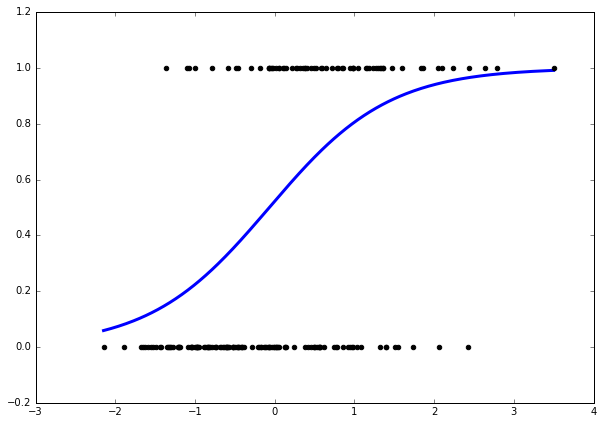

In [275]:
%matplotlib inline

def model(x):
    return 1 / (1 + numpy.exp(-x))

plt.figure(1, figsize = (10, 7))
#plt.logistic_estimator
plt.scatter(most_influential_predictor_1, y_test, color='black', zorder=20)
X_scaled_test_dummy = numpy.linspace(numpy.min(most_influential_predictor_1), numpy.max(most_influential_predictor_1), 300)

loss = model(X_scaled_test_dummy * coefficient_of_influential_predictor_1 + intercept_1).ravel()
plt.plot(X_scaled_test_dummy, loss, color = 'blue', linewidth = 3)

In the plot above we see a scatter plot of the actual test data (black dots). And we see the models estimates of the probability of a case being malignant (blue line). Bottom left the model is almost sure that the cases are benign; top right the model is almost sure that the cases are malignant.

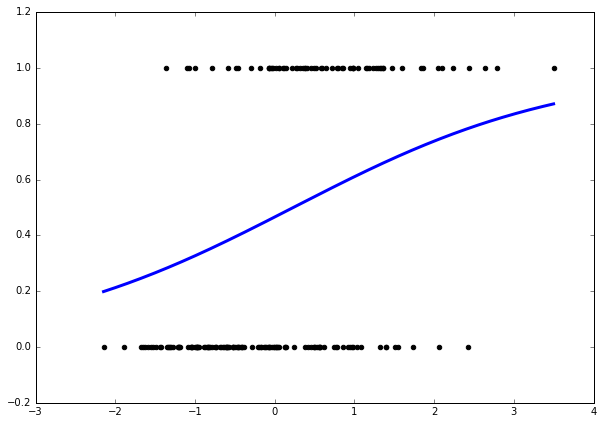

In [276]:
plt.figure(1, figsize = (10, 7))
plt.scatter(most_influential_predictor_2, y_test, color = 'black', zorder = 20)
X_scaled_test_dummy = numpy.linspace(numpy.min(most_influential_predictor_2), numpy.max(most_influential_predictor_2), 300)

loss = model(X_scaled_test_dummy * coefficient_of_influential_predictor_2 + intercept_2).ravel()
plt.plot(X_scaled_test_dummy, loss, color = 'blue', linewidth = 3)

In the second model, for small values of the $x$ coordinate the models is less sure that the case is benign -- it only gives a $20\%$ probability. For large values of the $x$ coordinate the models are less sure that the case is malignant -- it only gives a $80\%$ probability.

Looking at the above plots we see that in the first model where complex models are not penalised as strongly, the model is very certain that the cases for small values of the $x$ coordinate are $0$ (benign). It is also very certain that cases with large values of the $x$ coordinate are $1$ (malignant).

## 8. Provide a one-sentence summary for a non-technical audience. Then provide a longer paragraph-length technical explanation.

In this project we have seen that when we train models we have to carefully separate the notions of training and testing. We build models to make predictions on unseen data. Model scores on the training data are almost irrelevant.

It is possible to build a very complex model which performs perfectly on the training dataset, but does not perform well at all on the test dataset. This is called overfitting.

As we saw above, it is possible to make less complex model which performs less well on the training dataset. Which also performs better on the test dataset.

To avoid overfitting we optimised the penalty coefficient $C$. The optimal coefficient is found by considering the below loss function for the logistic regression estimator:

$$ \min_w \left (\frac{1}{2} \|w\|_2 + C \sum_{i = 1}^n \log \left (\exp(-[2y_i - 1] f(w, x_i) + 1\right) \right), $$

where $w$ are the coefficients of the regressors; $\|w\|_2$ is the $L_2$-norm of the coefficients; $C$ is penalty coefficient; the $y_i$ are the dependent variables; and the $x_i$ are the regressors. Finally, $f(w, x_i) = w_0 + w_1x_{i1} + \ldots + w_mx_{im}$.

The penalty coefficient $C$ determines what is penalised more: Misclassifications or large coefficients. If $C$ is very small then the first term in the above equation will be the most influential: That means that large coefficients will have the largest impact on the above. 

If $C$ is very large, then the second term in the above will be the most influential. For correctly classified points $-[2y_i - 1] f(w, x_i)$ is negative and therefore $\log \left (\exp(-[2y_i - 1] f(w, x_i) + 1\right)$ is close to 0. For incorrectly classified points $-[2y_i - 1] f(w, x_i)$ is positive and therefore $\log \left (\exp(-[2y_i - 1] f(w, x_i) + 1\right)$ can be large.

This means that for very large $C$, misclassified cases are relatively more important than model complexity. 

In the above, when we used $C = 1$, misclassifications were penalised more which meant that the models were very accurate on the training set. The models achieved greater accuracy by using larger coefficient values. This resulted in worse accuracy on the test sets, however.

When we optimised for $C$ we found that a value around $0.1$ lead to better generalisability. This means that misclassifications are relatively less important than large coefficients. This means that the models were less accurate on the training set, but did not get punished as severely for those inaccuracies. Because the model had smaller coefficients as a result, it was less complex. This means that it was less certain in its predictions, which meant that it was more accurate on the unseen test data.